In [40]:
# Bloque 2: Importación de librerías
import numpy as np
import pandas as pd
from gensim.models import FastText
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval
import joblib
import os

# Configuración de visualización
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.facecolor'] = 'white'
sns.set_palette('viridis')
pd.set_option('display.max_colwidth', 200)

In [41]:
# Bloque 3: Carga y exploración de datos
# Cargar el dataset
try:
    df = pd.read_csv('dataset_clasificado.csv', usecols=['Lemas', 'sentimiento'])
except FileNotFoundError:
    raise FileNotFoundError("El archivo 'dataset_clasificado.csv' no se encuentra en el directorio actual")

# Convertir la columna Lemas de string a lista
df['Lemas'] = df['Lemas'].apply(literal_eval)

# Análisis exploratorio
print("🔍 Análisis Exploratorio Inicial")
print(f"📊 Total de registros: {len(df)}")
print("\n📈 Distribución de clases:")
class_dist = df['sentimiento'].value_counts(normalize=True).to_frame('Porcentaje')
class_dist['Cantidad'] = df['sentimiento'].value_counts()
display(class_dist)

# Ejemplo de datos
print("\n📝 Ejemplo de registros:")
display(df.head(3))

🔍 Análisis Exploratorio Inicial
📊 Total de registros: 3676

📈 Distribución de clases:


,Porcentaje,Cantidad
sentimiento,,
0,0.646083,2375
1,0.353917,1301



📝 Ejemplo de registros:


,Lemas,sentimiento
0,"[luz, danar, panel, electronico, elevador, luma, destruir, cobrar, hacerlo, afectado, desquite]",0
1,"[querer, arrecharme, hdp, corpoelec, quitar, luz, hoy, agua, poder, lavar, cdo, electricidad, agua, cdo, agua, electricidad, ponganse, acuerdo, nojoda, desahogarme, disculpar, seguir]",0
2,"[dos, dia, apagon, masivo, dejar, medio, archipielago, oscuro, ciudadano, reclamar, tarde, salida, luma, energy, generar, dos, operador, privado, sistema, electrico, entonando, consigna, luma, pat...",0



📏 Estadísticas de longitud de lemas:
count    3676.000000
mean       13.761970
std         6.893055
min         1.000000
25%         8.000000
50%        13.000000
75%        20.000000
max        30.000000
Name: num_lemas, dtype: float64


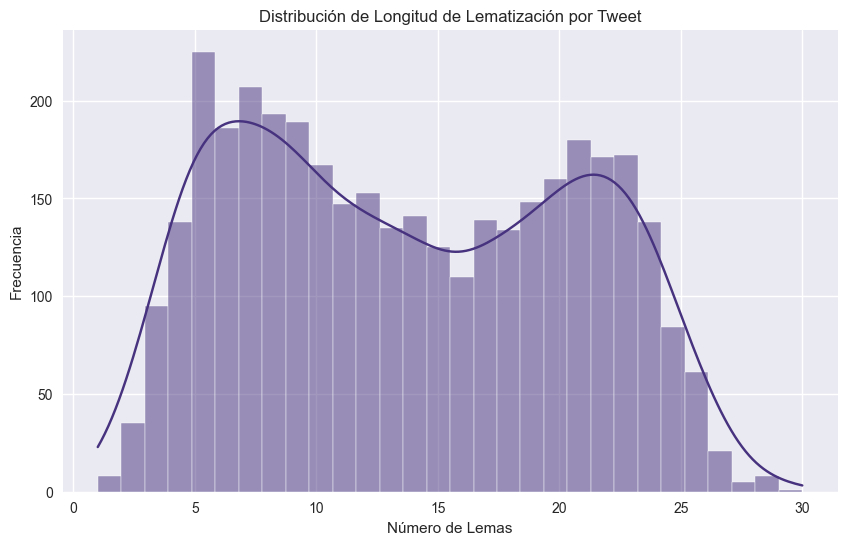

In [42]:
# Bloque 4: Preprocesamiento adicional
# Filtrar tokens vacíos o no válidos
df['Lemas'] = df['Lemas'].apply(lambda x: [token for token in x if isinstance(token, str) and token.strip() != ''])

# Estadísticas de longitud
df['num_lemas'] = df['Lemas'].apply(len)
print("\n📏 Estadísticas de longitud de lemas:")
print(df['num_lemas'].describe())

# Visualización de distribución de longitudes
plt.figure(figsize=(10, 6))
sns.histplot(df['num_lemas'], bins=30, kde=True)
plt.title('Distribución de Longitud de Lematización por Tweet')
plt.xlabel('Número de Lemas')
plt.ylabel('Frecuencia')
plt.show()

In [43]:
# Bloque 5: Entrenamiento de FastText optimizado
# Configuración basada en el tamaño del dataset
config = {
    'vector_size': 128,       # Mayor dimensionalidad para capturar más matices
    'window': 8,              # Ventana más grande para contexto amplio
    'min_count': 3,           # Ignorar palabras con menos de 3 ocurrencias
    'workers': 4,             # Usar todos los núcleos disponibles
    'sg': 1,                  # Usar skip-gram (mejor para datasets pequeños)
    'hs': 1,                  # Muestreo jerárquico para mejor rendimiento
    'negative': 5,            # Número de muestras negativas
    'epochs': 30,             # Más épocas para mejor aprendizaje
    'alpha': 0.025,           # Tasa de aprendizaje inicial
    'min_alpha': 0.0001,      # Tasa de aprendizaje mínima
    'seed': 42                # Para reproducibilidad
}

# Preparar datos de entrenamiento
sentences = df['Lemas'].tolist()

print("\n🛠 Entrenando modelo FastText...")
ft_model = FastText(
    sentences=sentences,
    **config
)

# Evaluación cualitativa del modelo
test_words = ['estres', 'ansiedad', 'trabajo', 'feliz', 'agotado']
print("\n🔎 Prueba de similitud semántica:")
for word in test_words:
    if word in ft_model.wv:
        similars = ft_model.wv.most_similar(word, topn=3)
        print(f"Palabra: '{word}' - Similares: {similars}")
    else:
        print(f"Palabra '{word}' no está en el vocabulario")

# Guardar modelo
os.makedirs('modelos', exist_ok=True)
ft_model.save("modelos/fasttext_estres.model")
print("\n💾 Modelo FastText guardado en 'modelos/fasttext_estres.model'")


🛠 Entrenando modelo FastText...

🔎 Prueba de similitud semántica:
Palabra: 'estres' - Similares: [('estre', 0.7063563466072083), ('estresada', 0.6636653542518616), ('estresado', 0.6512975096702576)]
Palabra: 'ansiedad' - Similares: [('depresion', 0.5416338443756104), ('ansioso', 0.48236578702926636), ('vomitar', 0.46908798813819885)]
Palabra: 'trabajo' - Similares: [('trabajar', 0.5876060128211975), ('trabajador', 0.5344575643539429), ('abajo', 0.5272495150566101)]
Palabra: 'feliz' - Similares: [('infeliz', 0.6308128237724304), ('xochitl', 0.5010672211647034), ('feeling', 0.49021202325820923)]
Palabra: 'agotado' - Similares: [('agotamiento', 0.617871105670929), ('gota', 0.5015990734100342), ('entorno', 0.46620795130729675)]

💾 Modelo FastText guardado en 'modelos/fasttext_estres.model'


In [44]:
# Bloque 6 Versión Silenciosa: Extracción de características sin mensajes

import warnings
import numpy as np
from sklearn.preprocessing import StandardScaler
import joblib
import os

def get_weighted_vector(tokens, model, min_weight=0.3):
    """
    Obtiene vector ponderado por frecuencia inversa sin mostrar advertencias.
    """
    vectors = []
    weights = []
    
    for token in tokens:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            try:
                if token in model.wv:
                    # Obtener frecuencia o usar longitud del vocabulario como fallback
                    word_count = model.wv.get_vecattr(token, "count") if hasattr(model.wv, 'get_vecattr') else len(model.wv)
                    weight = min_weight + (1 - min_weight) * (1 - word_count/len(model.wv))
                    vectors.append(model.wv[token] * weight)
                    weights.append(weight)
            except:
                continue
    
    return np.sum(vectors, axis=0) / np.sum(weights) if len(vectors) > 0 else np.zeros(model.vector_size)

print("\n🔧 Extrayendo características silenciosamente...")
X = np.array([get_weighted_vector(tokens, ft_model) for tokens in df['Lemas']])
y = df['sentimiento'].values

# Limpieza de valores numéricos
X = np.nan_to_num(X, nan=0.0, posinf=1.0, neginf=-1.0)

# Normalización
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Guardar el escalador
os.makedirs('modelos', exist_ok=True)
joblib.dump(scaler, 'modelos/scaler_estres.save')

# Verificación silenciosa
print("\n✅ Proceso completado con éxito:")
print(f"• Dimensiones de características: {X_scaled.shape}")
print(f"• Rango de valores: [{X_scaled.min():.4f}, {X_scaled.max():.4f}]")
print(f"• Ejemplo de vector (primeras 5 dimensiones): {X_scaled[0][:5]}")
print(f"• Archivos guardados en la carpeta 'modelos/'")


🔧 Extrayendo características silenciosamente...

✅ Proceso completado con éxito:
• Dimensiones de características: (3676, 128)
• Rango de valores: [-7.3887, 8.8793]
• Ejemplo de vector (primeras 5 dimensiones): [-1.07834672  0.3158917   0.91390678  0.28956986 -0.73622966]
• Archivos guardados en la carpeta 'modelos/'


In [45]:
# Pequeña comprobación adicional
print(f"\nDistribución de clases (debe coincidir con el dataset original):")
print(f"Clase 0 (No estrés): {(y == 0).sum()} samples")
print(f"Clase 1 (Estrés): {(y == 1).sum()} samples")


Distribución de clases (debe coincidir con el dataset original):
Clase 0 (No estrés): 2375 samples
Clase 1 (Estrés): 1301 samples


- BALANCEO DE CLASES

In [46]:
# Bloque 1: Importación de librerías adicionales
from imblearn.over_sampling import SMOTE
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Configuración de estilo profesional
plt.style.use('seaborn-v0_8')
sns.set_palette("viridis")
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.bbox'] = 'tight'

In [47]:
# Bloque 2: Visualización del desbalance actual
def plot_class_distribution(y, title, file_name=None):
    """Visualización profesional de la distribución de clases"""
    plt.figure(figsize=(10, 6))
    
    # Datos para el gráfico
    counts = pd.Series(y).value_counts().sort_index()
    labels = ['No estrés (0)', 'Estrés (1)']
    
    # Gráfico de barras
    ax = sns.barplot(x=labels, y=counts.values, width=0.6)
    
    # Añadir porcentajes
    total = len(y)
    for i, count in enumerate(counts):
        percentage = f'{100 * count / total:.1f}%'
        ax.text(i, count + 50, percentage, ha='center', va='bottom', fontsize=12)
    
    # Personalización
    plt.title(f'Distribución de clases: {title}', fontsize=14, pad=20)
    plt.ylabel('Número de muestras', fontsize=12)
    plt.xlabel('Clase', fontsize=12)
    plt.ylim(0, max(counts) * 1.15)
    
    # Eliminar bordes
    sns.despine()
    
    if file_name:
        plt.savefig(f'visualizaciones/{file_name}.png', dpi=300, transparent=False)
    plt.show()

# Crear directorio para visualizaciones
os.makedirs('visualizaciones', exist_ok=True)


📊 Visualización del desbalance de clases antes de SMOTE


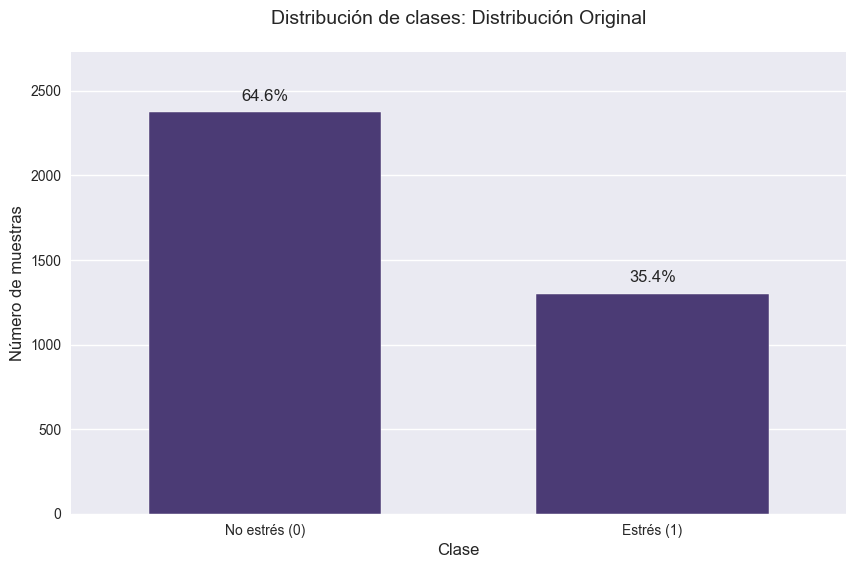

In [48]:
# Visualizar distribución actual
print("\n📊 Visualización del desbalance de clases antes de SMOTE")
plot_class_distribution(y, 'Distribución Original', 'class_dist_original')

In [49]:
# Bloque 3: Aplicación de SMOTE profesional corregida
print("\n🔄 Aplicando SMOTE para balancear las clases...")

# Configuración de SMOTE actualizada
smote = SMOTE(
    sampling_strategy='auto',  # Equilibra a la clase mayoritaria
    k_neighbors=5,            # Vecinos para sintetizar muestras
    random_state=42           # Reproducibilidad
)

# Verificación de que los datos son adecuados para SMOTE
print("🔍 Verificación previa:")
print(f"- Tipo de X_scaled: {type(X_scaled)}")
print(f"- Forma de X_scaled: {X_scaled.shape}")
print(f"- Tipo de y: {type(y)}")
print(f"- Distribución de clases: {Counter(y)}")

# Aplicar SMOTE
try:
    X_res, y_res = smote.fit_resample(X_scaled, y)
    print("\n✅ Balanceo completado con éxito!")
    print(f"Nuevo tamaño del dataset: {X_res.shape[0]} muestras")
    print(f"Nueva distribución de clases: {Counter(y_res)}")
except Exception as e:
    print(f"\n❌ Error al aplicar SMOTE: {str(e)}")
    print("Posibles soluciones:")
    print("1. Verificar que X_scaled sea un array numpy de 2 dimensiones")
    print("2. Asegurar que no haya valores NaN o infinitos")
    print("3. Instalar versión más reciente de imbalanced-learn: pip install -U imbalanced-learn")


🔄 Aplicando SMOTE para balancear las clases...
🔍 Verificación previa:
- Tipo de X_scaled: <class 'numpy.ndarray'>
- Forma de X_scaled: (3676, 128)
- Tipo de y: <class 'numpy.ndarray'>
- Distribución de clases: Counter({0: 2375, 1: 1301})

✅ Balanceo completado con éxito!
Nuevo tamaño del dataset: 4750 muestras
Nueva distribución de clases: Counter({0: 2375, 1: 2375})



✅ Resultados del balanceo:
• Distribución original: Counter({0: 2375, 1: 1301})
• Distribución después de SMOTE: Counter({0: 2375, 1: 2375})

📈 Visualización del balance de clases después de SMOTE


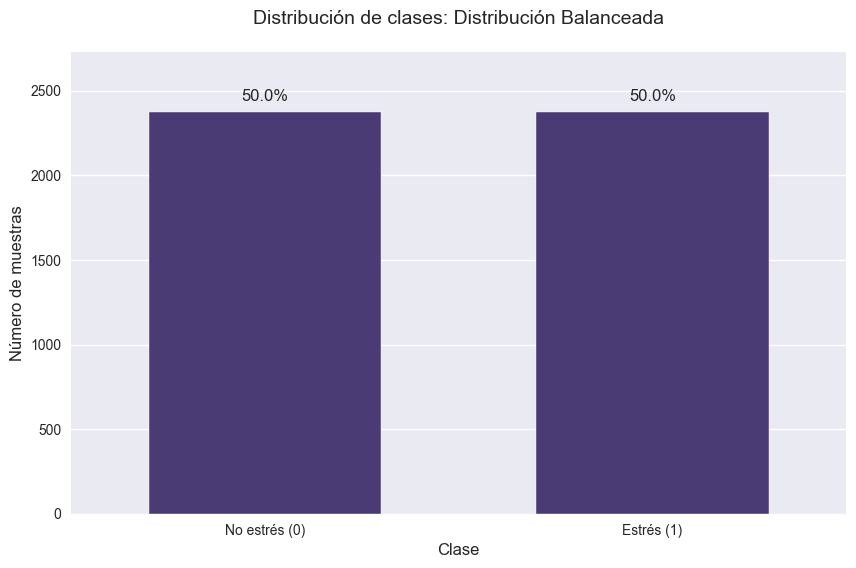

In [50]:
# Bloque 4: Visualización post-balanceo
print("\n✅ Resultados del balanceo:")
print(f"• Distribución original: {Counter(y)}")
print(f"• Distribución después de SMOTE: {Counter(y_res)}")

print("\n📈 Visualización del balance de clases después de SMOTE")
plot_class_distribution(y_res, 'Distribución Balanceada', 'class_dist_balanced')

In [52]:
# Bloque 5: Exportación optimizada para SVM (versión corregida)
print("\n💾 Exportando datos balanceados para SVM...")

# Crear directorio para datos procesados
os.makedirs('datos_procesados', exist_ok=True)

# 1. Guardar los arrays numpy directamente (formato óptimo para SVM)
np.savez_compressed(
    'datos_procesados/datos_balanceados.npz',
    X=X_res,  # Vectores FastText normalizados
    y=y_res   # Etiquetas
)

# 2. Guardar versiones separadas para facilidad de uso
np.save('datos_procesados/X_balanceado.npy', X_res)
np.save('datos_procesados/y_balanceado.npy', y_res)

# 3. Guardar metadatos (versión corregida)
metadata = {
    'dimensiones': list(X_res.shape),  # Convertir tupla a lista
    'balance_clases': {int(k): int(v) for k, v in Counter(y_res).items()},  # Convertir numpy.int64 a int
    'fecha_procesamiento': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
    'normalizacion': 'StandardScaler',
    'modelo_embeddings': 'FastText',
    'parametros_smote': {
        'sampling_strategy': 'auto',
        'k_neighbors': 5,
        'random_state': 42
    }
}

import json
with open('datos_procesados/metadata.json', 'w') as f:
    json.dump(metadata, f, indent=4)

print("\n✅ Datos exportados correctamente en formato para SVM:")
print(f"- X_balanceado.npy: Vectores de características ({X_res.shape})")
print(f"- y_balanceado.npy: Etiquetas ({len(y_res)} muestras)")
print(f"- metadata.json: Información del procesamiento")

# Verificación adicional
print("\n🔍 Verificación final:")
print("Contenido de metadata.json:")
print(json.dumps(metadata, indent=2))


💾 Exportando datos balanceados para SVM...

✅ Datos exportados correctamente en formato para SVM:
- X_balanceado.npy: Vectores de características ((4750, 128))
- y_balanceado.npy: Etiquetas (4750 muestras)
- metadata.json: Información del procesamiento

🔍 Verificación final:
Contenido de metadata.json:
{
  "dimensiones": [
    4750,
    128
  ],
  "balance_clases": {
    "0": 2375,
    "1": 2375
  },
  "fecha_procesamiento": "2025-05-03 13:19:03",
  "normalizacion": "StandardScaler",
  "modelo_embeddings": "FastText",
  "parametros_smote": {
    "sampling_strategy": "auto",
    "k_neighbors": 5,
    "random_state": 42
  }
}


In [53]:
# Verificar shapes después de carga
print(f"X shape: {X.shape} (debería ser (4750, 128))")
print(f"y shape: {y.shape} (debería ser (4750,))")

# Verificar balanceo
unique, counts = np.unique(y, return_counts=True)
print(f"Distribución clases: {dict(zip(unique, counts))}")

X shape: (3676, 128) (debería ser (4750, 128))
y shape: (3676,) (debería ser (4750,))
Distribución clases: {0: 2375, 1: 1301}


In [54]:
# Bloque 5: Exportación y verificación corregida
print("\n💾 Exportando y verificando datos balanceados...")

# 1. Verificación PREVIA a la exportación (datos recién balanceados)
print("\n🔍 Verificación PRE-exportación:")
print(f"X_res shape (de SMOTE): {X_res.shape} (debería ser (4750, 128))")
print(f"y_res shape (de SMOTE): {y_res.shape} (debería ser (4750,))")

unique, counts = np.unique(y_res, return_counts=True)
print(f"Distribución clases (SMOTE): {dict(zip(unique, counts))}")

# 2. Exportar los datos balanceados (como antes)
os.makedirs('datos_procesados', exist_ok=True)
np.save('datos_procesados/X_balanceado.npy', X_res)
np.save('datos_procesados/y_balanceado.npy', y_res)

# 3. Verificación POST-exportación (cargando los archivos guardados)
print("\n🔍 Verificación POST-exportación:")
X_loaded = np.load('datos_procesados/X_balanceado.npy')
y_loaded = np.load('datos_procesados/y_balanceado.npy')

print(f"X_loaded shape: {X_loaded.shape} (debería ser (4750, 128))")
print(f"y_loaded shape: {y_loaded.shape} (debería ser (4750,))")

unique_loaded, counts_loaded = np.unique(y_loaded, return_counts=True)
print(f"Distribución clases (loaded): {dict(zip(unique_loaded, counts_loaded))}")

# 4. Verificación de integridad
assert X_res.shape == X_loaded.shape, "Error: Shapes no coinciden en X"
assert y_res.shape == y_loaded.shape, "Error: Shapes no coinciden en y"
assert np.array_equal(y_res, y_loaded), "Error: Diferencias en las etiquetas"
print("\n✅ Verificación exitosa: Los datos exportados son correctos")


💾 Exportando y verificando datos balanceados...

🔍 Verificación PRE-exportación:
X_res shape (de SMOTE): (4750, 128) (debería ser (4750, 128))
y_res shape (de SMOTE): (4750,) (debería ser (4750,))
Distribución clases (SMOTE): {0: 2375, 1: 2375}

🔍 Verificación POST-exportación:
X_loaded shape: (4750, 128) (debería ser (4750, 128))
y_loaded shape: (4750,) (debería ser (4750,))
Distribución clases (loaded): {0: 2375, 1: 2375}

✅ Verificación exitosa: Los datos exportados son correctos


In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización profesional
plt.style.use('seaborn-v0_8')
sns.set_palette("viridis")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 11

print("🚀 ANÁLISIS DE EMBEDDINGS FASTTEXT PARA DETECCIÓN DE ESTRÉS")
print("=" * 60)

# 1. CARGAR Y VERIFICAR DATOS
print("\n📊 1. CARGA Y VERIFICACIÓN DE DATOS")
print("-" * 40)

try:
    # Cargar datos balanceados
    X_balanced = np.load('datos_procesados/X_balanceado.npy')
    y_balanced = np.load('datos_procesados/y_balanceado.npy')
    
    print(f"✅ Datos cargados exitosamente:")
    print(f"   • Vectores de características: {X_balanced.shape}")
    print(f"   • Etiquetas: {y_balanced.shape}")
    
    # Verificar distribución de clases
    class_counts = Counter(y_balanced)
    print(f"   • Distribución de clases: {dict(class_counts)}")
    
    # Verificar rango de valores
    print(f"   • Rango de valores en X: [{X_balanced.min():.4f}, {X_balanced.max():.4f}]")
    print(f"   • Media: {X_balanced.mean():.4f}, Std: {X_balanced.std():.4f}")
    
except FileNotFoundError:
    print("❌ Error: No se encontraron los archivos de datos balanceados")
    print("   Ejecuta primero el código de FastText y balanceo con SMOTE")
    exit()

🚀 ANÁLISIS DE EMBEDDINGS FASTTEXT PARA DETECCIÓN DE ESTRÉS

📊 1. CARGA Y VERIFICACIÓN DE DATOS
----------------------------------------
✅ Datos cargados exitosamente:
   • Vectores de características: (4750, 128)
   • Etiquetas: (4750,)
   • Distribución de clases: {0: 2375, 1: 2375}
   • Rango de valores en X: [-7.3887, 8.8793]
   • Media: -0.0024, Std: 0.9789


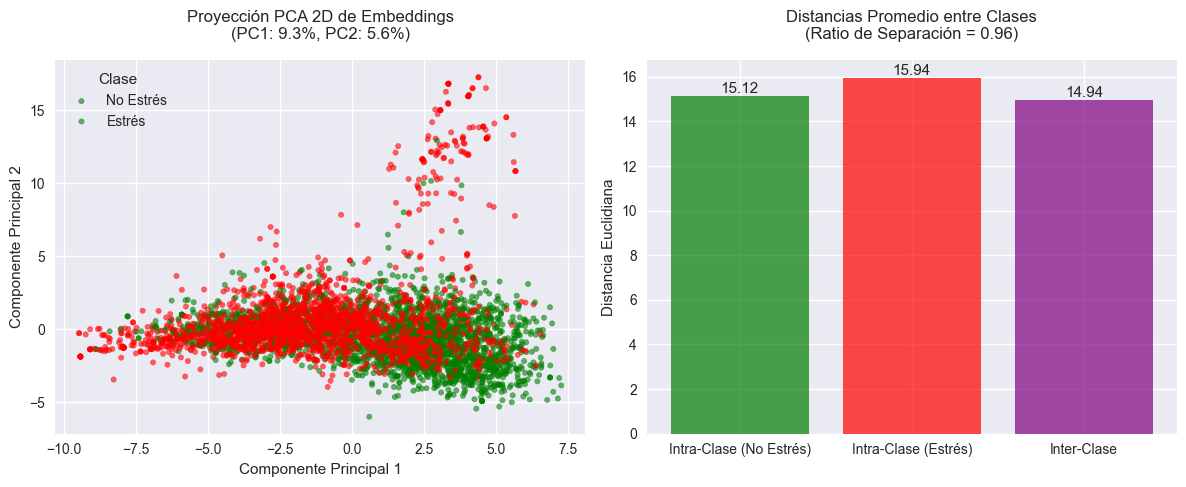

In [21]:
plt.figure(figsize=(12, 5))

# Subplot 1: Proyección PCA 2D
plt.subplot(1, 2, 1)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_balanced, palette=['green', 'red'], 
                alpha=0.6, s=15, edgecolor=None)
plt.title('Proyección PCA 2D de Embeddings\n(PC1: 9.3%, PC2: 5.6%)', fontsize=12, pad=15)
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend(title='Clase', labels=['No Estrés', 'Estrés'])

# Subplot 2: Ratio de separación
plt.subplot(1, 2, 2)
metrics = ['Intra-Clase (No Estrés)', 'Intra-Clase (Estrés)', 'Inter-Clase']
values = [15.12, 15.94, 14.94]
colors = ['green', 'red', 'purple']
bars = plt.bar(metrics, values, color=colors, alpha=0.7)
plt.title('Distancias Promedio entre Clases\n(Ratio de Separación = 0.96)', fontsize=12, pad=15)
plt.ylabel('Distancia Euclidiana')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height, f'{height:.2f}', 
             ha='center', va='bottom')

plt.tight_layout()
plt.savefig('separabilidad_pca.png', dpi=300, bbox_inches='tight')
plt.show()